In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformation for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size (224x224)
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

batch_size = 10

# Load Food101 dataset
train_dataset = datasets.Food101(root="./data", split="train", transform=transform, download=True)
test_dataset = datasets.Food101(root="./data", split="test", transform=transform, download=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Get the classes
classes = train_dataset.classes

# Display dataset info
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Number of classes: 101
Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_an

In [2]:
train_size = min(len(train_dataset), 1000)
test_size = min(len(test_dataset), 500)
train_dataset = torch.utils.data.Subset(train_dataset, range(train_size))
test_dataset = torch.utils.data.Subset(test_dataset, range(test_size))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

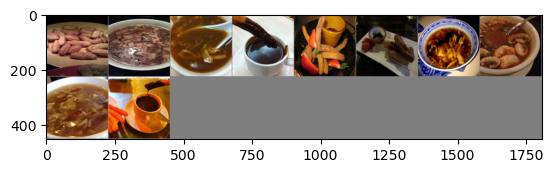

churros hot_and_sour_soup hot_and_sour_soup churros churros churros hot_and_sour_soup hot_and_sour_soup hot_and_sour_soup churros


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

def imshow(img):
    img = img * 0.5 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
# !pip install --upgrade torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class FoodClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FoodClassifier, self).__init__()

        self.conv_layer1 = nn.Conv2d(3, 64, kernel_size=2, padding=1)
        self.norm1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv_layer2 = nn.Conv2d(64, 128, kernel_size=2, padding=1)
        self.norm2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)


        self.conv_layer3 = nn.Conv2d(128, 256, kernel_size=2, padding=1)
        self.norm3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        # # Calculate the correct flattened size dynamically
        self.flatten_size = self._get_flatten_size()

        self.fc_layer1 = nn.Linear(self.flatten_size, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc_layer2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)

        self.fc_layer3 = nn.Linear(256, num_classes)

    def _get_flatten_size(self):
        """Pass a dummy tensor to get the correct flattened size."""
        with torch.no_grad():
            x = torch.randn(1, 3, 224, 224)  # Simulate a single image input
            x = self.pool1(F.relu(self.norm1(self.conv_layer1(x))))
            x = self.pool2(F.relu(self.norm2(self.conv_layer2(x))))
            x = self.pool3(F.relu(self.norm3(self.conv_layer3(x))))
            return torch.flatten(x, 1).shape[1]  # Get the correct output size


    def forward(self, x):
        x = self.pool1(F.relu(self.norm1(self.conv_layer1(x))))
        x = self.pool2(F.relu(self.norm2(self.conv_layer2(x))))
        x = self.pool3(F.relu(self.norm3(self.conv_layer3(x))))

        x = torch.flatten(x, 1)  # Flatten before FC layers
        x = F.relu(self.fc_layer1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc_layer2(x))
        x = self.dropout2(x)
        x = self.fc_layer3(x)  # Output layer (raw logits)

        return x

num_classes = 101
food = FoodClassifier(num_classes)

In [6]:

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
food.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(food.parameters(), lr=0.001)

# ReduceLROnPlateau without deprecated 'verbose' parameter
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Monitor learning rate during training
def get_lr():
    return scheduler.optimizer.param_groups[0]['lr']

print("Initial Learning Rate:", get_lr())

Initial Learning Rate: 0.001


In [8]:

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
   running_loss = 0.0
   food.train()

   for i, data in enumerate(train_loader, 0):
       inputs, labels = data[0].to(device), data[1].to(device)
       optimizer.zero_grad()
       outputs = food(inputs)
       loss = criterion(outputs, labels)
       loss.backward()
       optimizer.step()

       running_loss += loss.item()
       if i % 100 == 99:
           print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
           # Update learning rate based on running loss
           scheduler.step(running_loss)
           running_loss = 0.0

[1,   100] loss: 10.717
[2,   100] loss: 1.541


In [9]:
PATH = './cifar_net.pth'
torch.save(food.state_dict(), PATH)

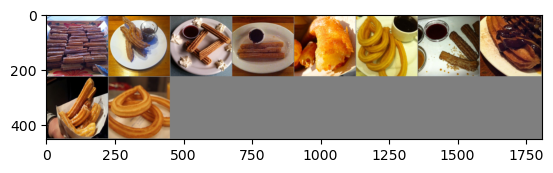

GroundTruth:  churros churros churros churros churros churros churros churros churros churros


In [10]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
# num_classes = 101
# food = FoodClassifier(num_classes)
food.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [12]:
outputs = food(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  churros churros hot_and_sour_soup churros hot_and_sour_soup churros churros churros churros churros


In [14]:
'''The results seem pretty good.

Let us look at how the network performs on the whole dataset.'''
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Fix
        outputs = food(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 100 test images: {100 * correct // total} %')

Accuracy of the network on the 100 test images: 65 %


In [15]:
'''That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

 what are the classes that performed well, and the classes that did not perform well:

'''
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = food(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

ZeroDivisionError: float division by zero